In [33]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from itertools import combinations

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
from pytorch_tabnet.tab_model import TabNetClassifier

from numpy import array
from matplotlib import pyplot as plt
%matplotlib inline

from MetsDataByGender import get_mets_data
from MetsEvaluation import get_calib_metric, get_metric, calibrated_plot, get_feature_importance, get_z_test, get_calib_prob

### Logistic Regression

In [44]:
#For Logistic Regression
fts = ['BPWC_add', 'weight', 'BFP', 'sm_total', 'wc', 'BAI', 'sex', 'height', 'bWC', 'BP']
args = {'C': 5, 'solver': 'liblinear','penalty' : 'l1','random_state' : 100}

tr, val, ts, info, beta, tau, ctg_idxs, ctg_dims = get_mets_data(fts_ctg='', fts = fts, gender=None, ONEHOT=True, TABNET=False, mrmr=False,SEED=100)

X_train = tr.iloc[:,1:]
y_train = tr.iloc[:,0]
X_valid = val.iloc[:,1:]
y_valid = val.iloc[:,0]
X_test = ts.iloc[:,1:]
y_test = ts.iloc[:,0]

sc = StandardScaler()
sX_train = sc.fit_transform(X_train)
sX_valid = sc.transform(X_valid)
sX_test = sc.transform(X_test)

X_train = pd.DataFrame(sX_train, columns=X_train.columns)
X_valid = pd.DataFrame(sX_valid, columns=X_valid.columns)
X_test = pd.DataFrame(sX_test, columns=X_test.columns)

In [45]:
lr_model = LogisticRegression(**args)
lr_model.fit(X_train,y_train)

prob_lr = lr_model.predict_proba(X_test)
get_metric(prob_lr, y_test, 0.5)

{'acc': 0.8021884325706977,
 'bac': 0.8138066955511164,
 'recall': 0.8295081967213115,
 'ppv': 0.3804511278195489,
 'npv': 0.9690598968663229,
 'sepecificity': 0.7981051943809213,
 'f1': 0.5216494845360824,
 'auc': 0.8926433912986041}

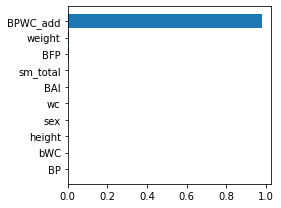

[3.55150669e+02 2.99201922e+00 1.86463623e+00 1.05961207e+00
 6.48253480e-01 6.12312097e-01 4.96262849e-01 3.62689607e-01
 1.82551479e-01 3.67799712e-02]


In [46]:
coef = np.exp(lr_model.coef_.reshape(-1))
r_coef = coef/np.sum(coef)
fts = get_feature_importance(r_coef, X_train.columns,10)

plt.figure(figsize=(4,3))
plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./fig/feature_logisticregression.png')
plt.show()
print(np.sort(coef)[::-1])

==== Calibration ====
Accuracy : 0.8021884325706977
Balanced Accuracy : 0.8138066955511164
Sensitivity :  0.8295081967213115
PPV :  0.3804511278195489
NPV :  0.9690598968663229
Specificity :  0.7981051943809213
F1 score :  0.5216494845360824
AUC :  0.8926433912986041


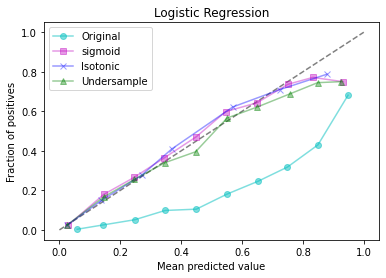

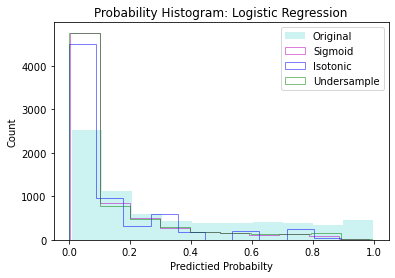

{'original': 0.13569660915663947, 'sigmoid': 0.07758529172079377, 'isotonic': 0.07776558076023074, 'underample': 0.0777071991201207} {'original': 2.1916417276955764, 'sigmoid': 0.8567975632366911, 'isotonic': 0.7375412207600245, 'underample': 1.9118251038101841} {'original': 0.028405386430231692, 'sigmoid': 0.3915567726303584, 'isotonic': 0.46079328547783016, 'underample': 0.05589863071793102}


In [17]:
score, z, p = calibrated_plot('Logistic Regression', lr_model, X_train, y_train, X_valid, y_valid, X_test, y_test, beta, tau)
print(score, z, p)

### Decision Tree (CART)

In [79]:
#For Tree
# all
fts = ['BPWC_add', 'BPWC_mul', 'BPWC_dif']
args = {'criterion': 'gini','max_depth': 5,'max_features': None,'min_samples_leaf': 200,'min_samples_split': 0.01,'splitter': 'best','random_state': 100}

tr, val, ts, info, beta, tau, ctg_idxs, ctg_dims = get_mets_data(fts_ctg='', fts = fts, gender=None, ONEHOT=True, TABNET=False, mrmr=False,SEED=210)

X_train = tr.iloc[:,1:]
y_train = tr.iloc[:,0]
X_valid = val.iloc[:,1:]
y_valid = val.iloc[:,0]
X_test = ts.iloc[:,1:]
y_test = ts.iloc[:,0]

In [80]:
dt_model = DecisionTreeClassifier(**args)
dt_model.fit(X_train,y_train)
prob_dt = dt_model.predict_proba(X_test)
get_metric(prob_dt, y_test, 0.5)

{'acc': 0.7834304391075743,
 'bac': 0.8151846415996751,
 'recall': 0.8586497890295358,
 'ppv': 0.36932849364791287,
 'npv': 0.9722739499275812,
 'sepecificity': 0.7717194941698144,
 'f1': 0.516497461928934,
 'auc': 0.8882925424764725}

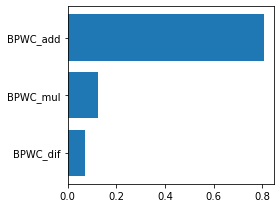

In [82]:
fts = get_feature_importance(dt_model.feature_importances_, X_train.columns,10)
plt.figure(figsize=(4,3))
plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./fig/feature_decisiontree.png')
plt.show()

==== Calibration ====
Accuracy : 0.7834304391075743
Balanced Accuracy : 0.8151846415996751
Sensitivity :  0.8586497890295358
PPV :  0.36932849364791287
NPV :  0.9722739499275812
Specificity :  0.7717194941698144
F1 score :  0.516497461928934
AUC :  0.8882925424764725


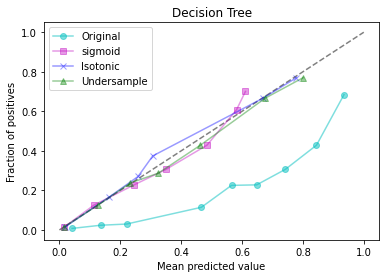

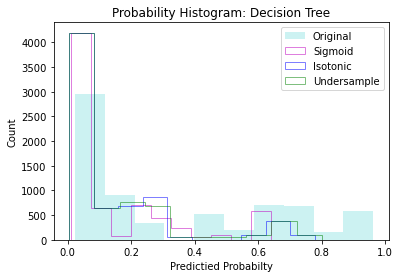

{'original': 0.14030331303187188, 'sigmoid': 0.07938280661704049, 'isotonic': 0.07878105902772867, 'underample': 0.07861574219805638} {'original': 8.223627242013718, 'sigmoid': -1.6149171084634646, 'isotonic': -0.25785333249038667, 'underample': -0.02071327718635983} {'original': 1.9743909071871044e-16, 'sigmoid': 0.10632864677341512, 'isotonic': 0.796520102423179, 'underample': 0.9834743776295843}


In [83]:
score, z, p = calibrated_plot('Decision Tree', dt_model, X_train, y_train, X_valid, y_valid, X_test, y_test, beta, tau)
print(score, z, p)

In [84]:
cali_prob = get_calib_metric(prob_dt[:,1], y_test, beta, tau)

==== Calibration ====
Accuracy : 0.7834304391075743
Balanced Accuracy : 0.8151846415996751
Sensitivity :  0.8586497890295358
PPV :  0.36932849364791287
NPV :  0.9722739499275812
Specificity :  0.7717194941698144
F1 score :  0.516497461928934
AUC :  0.8882925424764725


In [85]:
from sklearn import tree
dt_model_text = tree.export_text(dt_model,
                                 feature_names=X_train.columns.to_list())

print(dt_model_text)

|--- BPWC_add <= 0.66
|   |--- BPWC_dif <= -0.34
|   |   |--- class: 0
|   |--- BPWC_dif >  -0.34
|   |   |--- BPWC_add <= 0.42
|   |   |   |--- BPWC_dif <= -0.13
|   |   |   |   |--- BPWC_mul <= 0.02
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BPWC_mul >  0.02
|   |   |   |   |   |--- class: 0
|   |   |   |--- BPWC_dif >  -0.13
|   |   |   |   |--- BPWC_add <= 0.33
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BPWC_add >  0.33
|   |   |   |   |   |--- class: 0
|   |   |--- BPWC_add >  0.42
|   |   |   |--- BPWC_dif <= -0.06
|   |   |   |   |--- BPWC_dif <= -0.12
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BPWC_dif >  -0.12
|   |   |   |   |   |--- class: 0
|   |   |   |--- BPWC_dif >  -0.06
|   |   |   |   |--- BPWC_add <= 0.56
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BPWC_add >  0.56
|   |   |   |   |   |--- class: 0
|--- BPWC_add >  0.66
|   |--- BPWC_mul <= 0.27
|   |   |--- BPWC_dif <= -0.24
|   |   |   |--- BPWC_add <= 0.93
|   |   |  

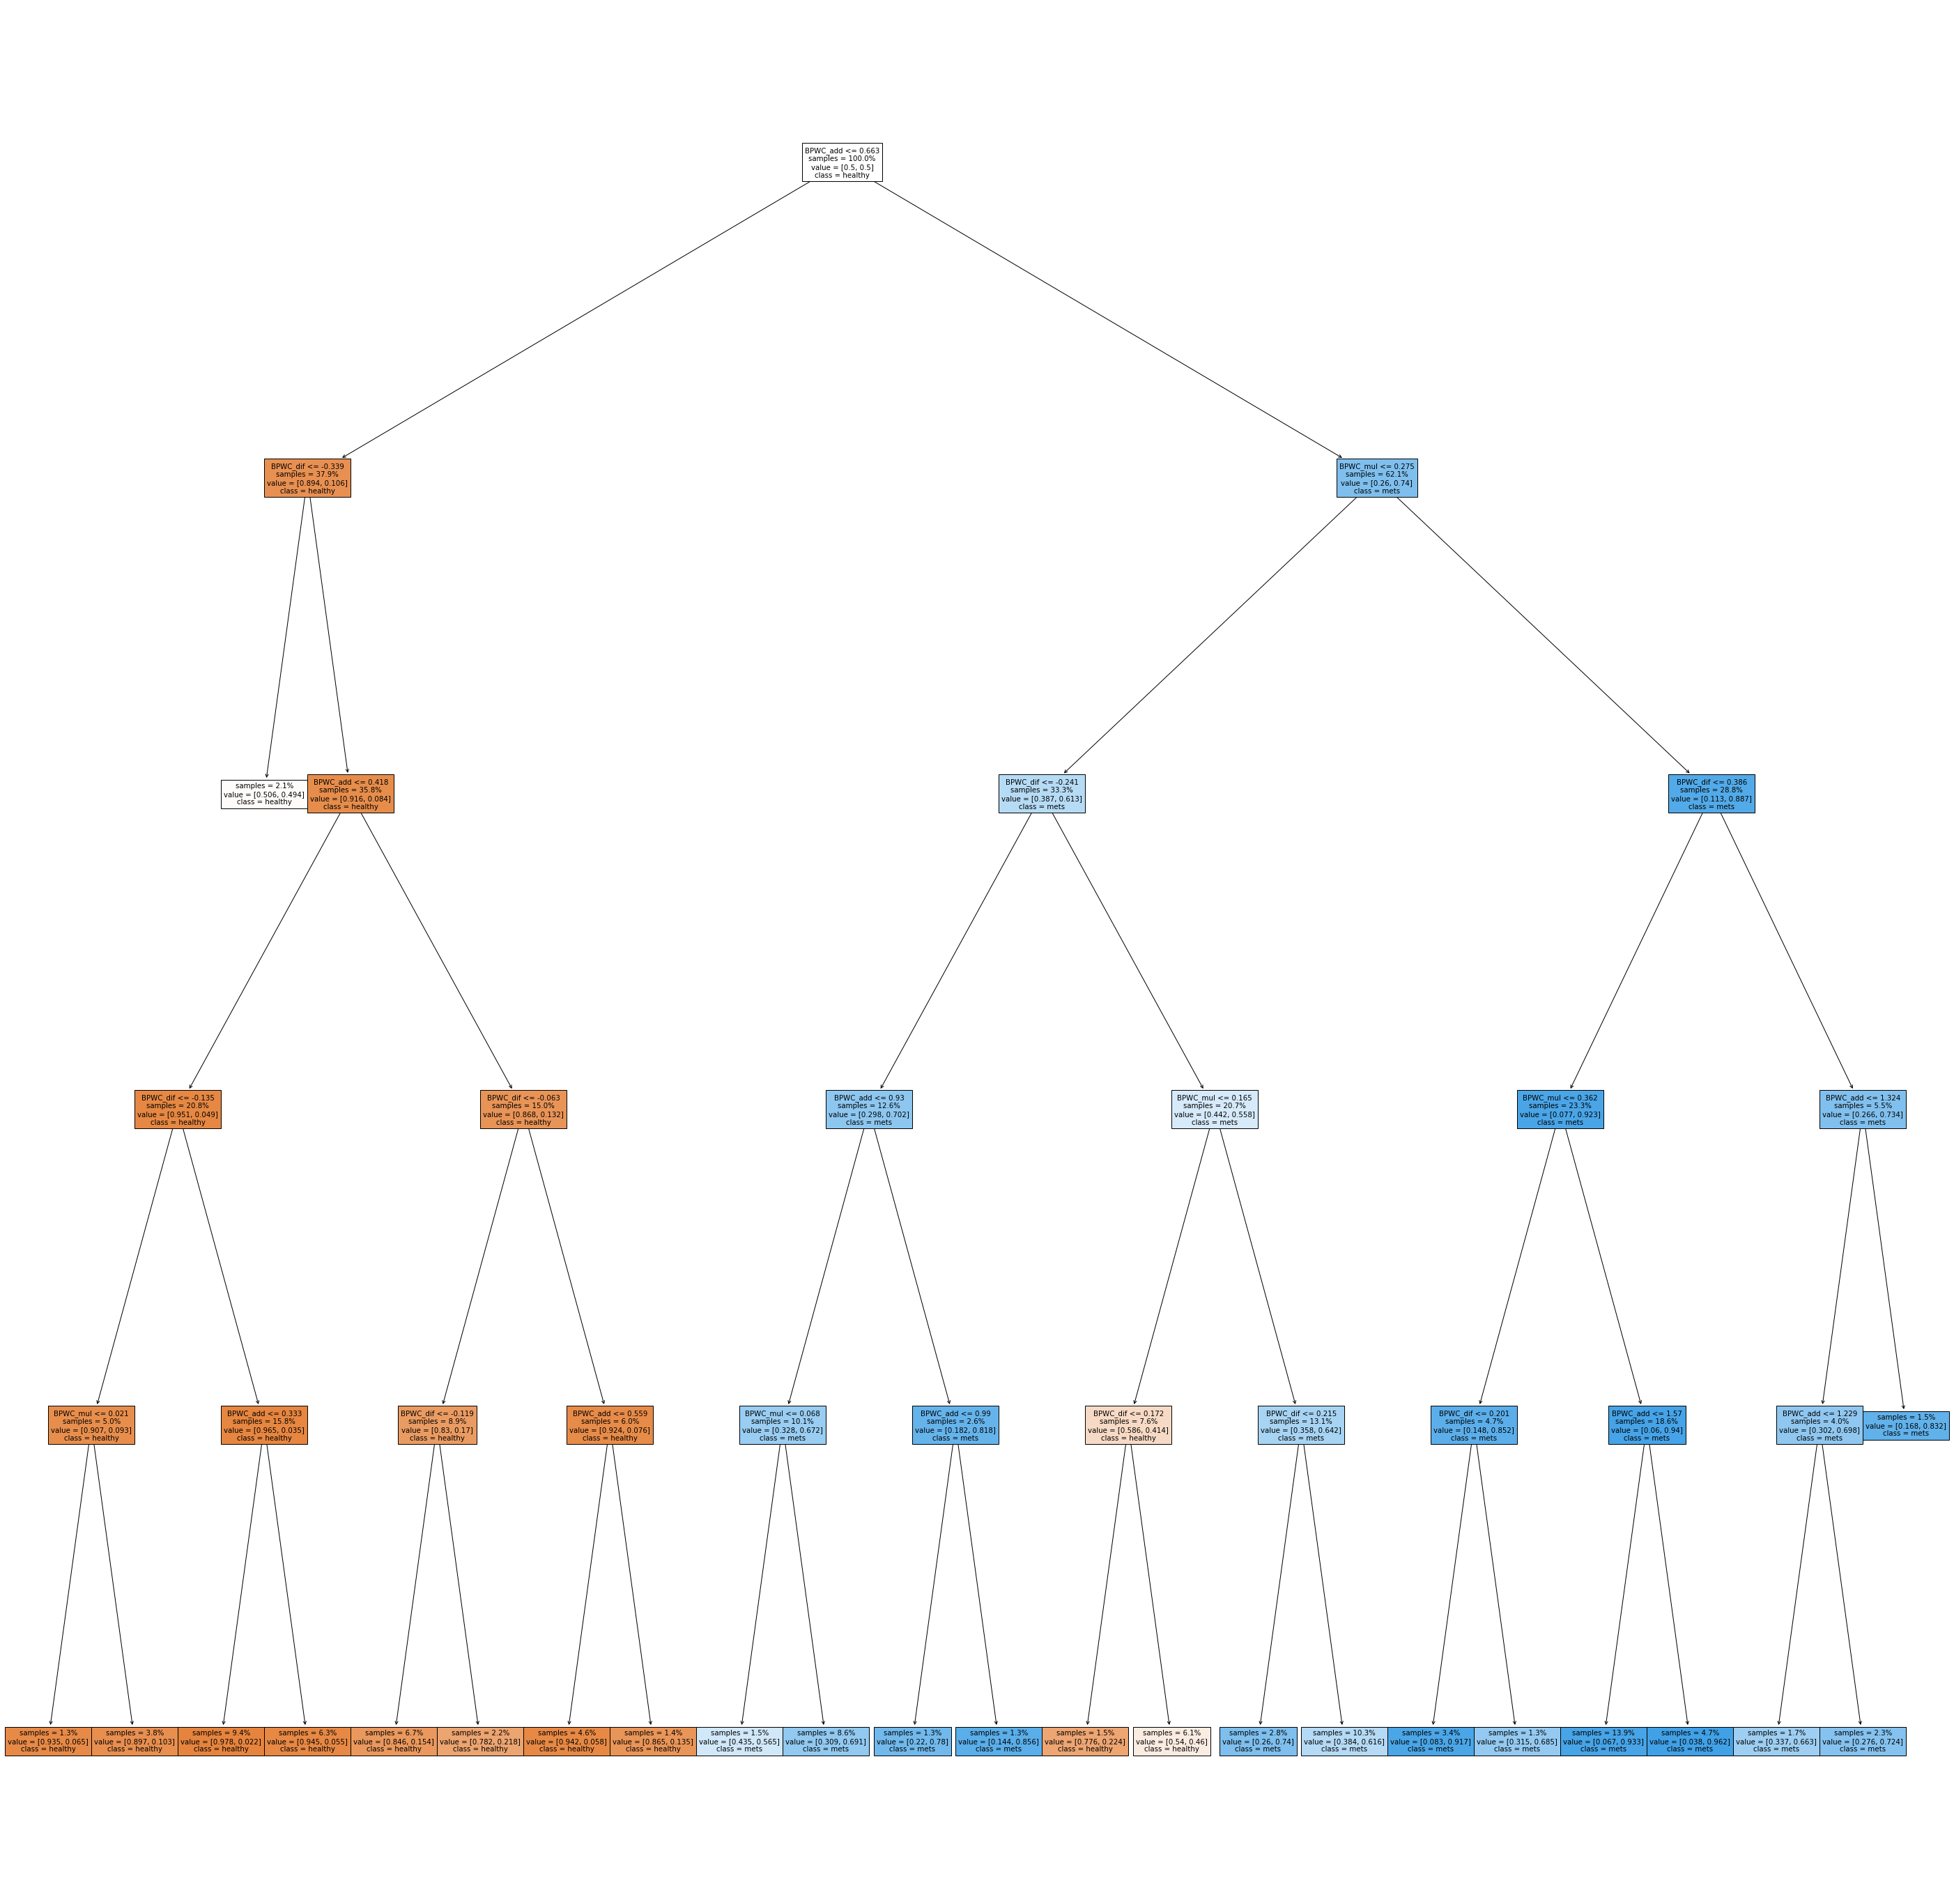

In [86]:
fig = plt.figure(figsize=(50,50))
tree.plot_tree(dt_model,
               feature_names=X_train.columns.to_list(),
               proportion=True,
               class_names=['healthy','mets'],
               filled=True, impurity=False)
plt.savefig('./fig/tree_plot.png')
plt.show()

### Random Forest

In [50]:
#For Random Forest
fts = ['BPWC_add', 'bWC', 'AVI', 'WHtR', 'BPWC_dif', 'bmi', 'BFP', 'fate']
args = {'bootstrap': True,'max_depth': 7,'min_samples_leaf': 2,'min_samples_split': 5,'n_estimators': 1000,'random_state' : 100}

tr, val, ts, info, beta, tau, ctg_idxs, ctg_dims = get_mets_data(fts_ctg='', fts = fts, gender=None, ONEHOT=True, TABNET=False, mrmr=False, SEED=100)

X_train = tr.iloc[:,1:]
y_train = tr.iloc[:,0]
X_valid = val.iloc[:,1:]
y_valid = val.iloc[:,0]
X_test = ts.iloc[:,1:]
y_test = ts.iloc[:,0]

In [51]:
rf_model = RandomForestClassifier(**args)
rf_model.fit(X_train,y_train)

prob_rf = rf_model.predict_proba(X_test)
get_metric(prob_rf, y_test, 0.5)

{'acc': 0.7690777319880631,
 'bac': 0.8170861874133065,
 'recall': 0.8819672131147541,
 'ppv': 0.3472461273666093,
 'npv': 0.9770846594525779,
 'sepecificity': 0.7522051617118589,
 'f1': 0.49830194504476694,
 'auc': 0.8931100411844408}

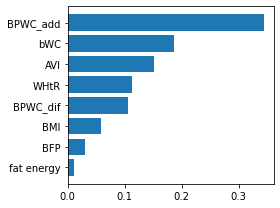

In [55]:
fts = get_feature_importance(rf_model.feature_importances_, X_train.columns,10)

plt.figure(figsize=(4,3))
plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./fig/feature_randomforest.png')
plt.show()

==== Calibration ====
Accuracy : 0.7690777319880631
Balanced Accuracy : 0.8170861874133065
Sensitivity :  0.8819672131147541
PPV :  0.3472461273666093
NPV :  0.9770846594525779
Specificity :  0.7522051617118589
F1 score :  0.49830194504476694
AUC :  0.8931100411844408


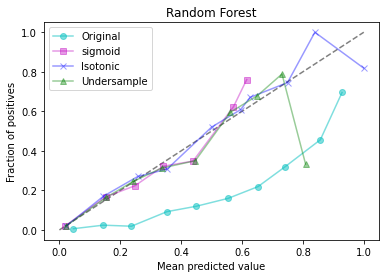

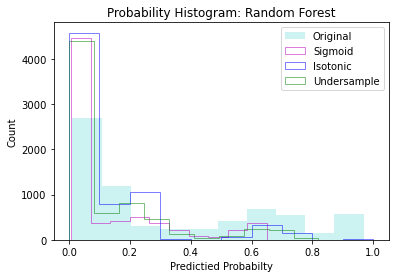

{'original': 0.13766723467855016, 'sigmoid': 0.07692017508741132, 'isotonic': 0.07607943963292664, 'underample': 0.07595209073948189} {'original': 6.078335346341746, 'sigmoid': -0.7465638769546257, 'isotonic': 0.580164447321069, 'underample': -0.6536450746329934} {'original': 1.2143658824764078e-09, 'sigmoid': 0.4553268601406256, 'isotonic': 0.5618037264091327, 'underample': 0.5133404971805009}


In [28]:
score, z, p = calibrated_plot('Random Forest', rf_model, X_train, y_train, X_valid, y_valid, X_test, y_test, beta, tau)
print(score, z, p)

### Xgboost

In [56]:
#For Xgboost
fts = ['BPWC_mul', 'BPWC_dif', 'wc', 'w014', 'w019', 'dbp']
args = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6,'objective':'binary:logistic', 'booster':'gbtree','n_jobs':-1,'random_state':100,'seed':None}

tr, val, ts, info, beta, tau, ctg_idxs, ctg_dims = get_mets_data(fts_ctg='', fts = fts, gender=None, ONEHOT=True, TABNET=False, mrmr=False, SEED=100)

X_train = tr.iloc[:,1:]
y_train = tr.iloc[:,0]
X_valid = val.iloc[:,1:]
y_valid = val.iloc[:,0]
X_test = ts.iloc[:,1:]
y_test = ts.iloc[:,0]

In [57]:
xgb_model = XGBClassifier(**args)
xgb_model.fit(X_train,y_train)

prob_xgb = xgb_model.predict_proba(X_test)
get_metric(prob_xgb, y_test, 0.5)

{'acc': 0.7665198237885462,
 'bac': 0.8114331007224683,
 'recall': 0.8721311475409836,
 'ppv': 0.3433734939759036,
 'npv': 0.9751750477402928,
 'sepecificity': 0.750735053903953,
 'f1': 0.4927446742821859,
 'auc': 0.8907832184560566}

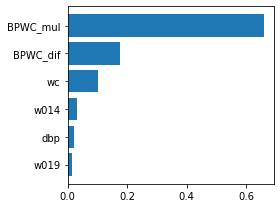

In [58]:
fts = get_feature_importance(xgb_model.feature_importances_, X_train.columns,10)
plt.figure(figsize=(4,3))
plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./fig/feature_xgboost.png')
plt.show()

==== Calibration ====
Accuracy : 0.7665198237885462
Balanced Accuracy : 0.8114331007224683
Sensitivity :  0.8721311475409836
PPV :  0.3433734939759036
NPV :  0.9751750477402928
Specificity :  0.750735053903953
F1 score :  0.4927446742821859
AUC :  0.8907832184560566


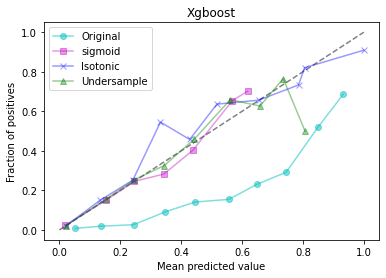

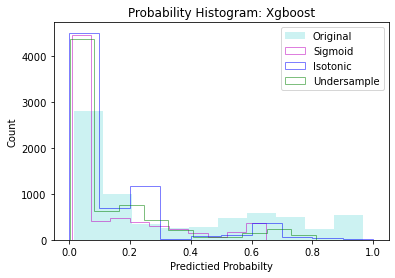

{'original': 0.13835175208182351, 'sigmoid': 0.07760374024802344, 'isotonic': 0.07696389141691622, 'underample': 0.07680987922514657} {'original': 5.2789940858877475, 'sigmoid': -0.3607917450832589, 'isotonic': 1.012095410757995, 'underample': -0.17690530910760374} {'original': 1.2989499699403022e-07, 'sigmoid': 0.7182551342313759, 'isotonic': 0.3114924364585995, 'underample': 0.8595827683330712}


In [32]:
score, z, p = calibrated_plot('Xgboost', xgb_model, X_train, y_train, X_valid, y_valid, X_test, y_test, beta, tau)
print(score, z, p)

### TabNet

In [59]:
# For TabNet
fts = ['BPWC_add', 'WC', 'AVI', 'bmi', 'pulse', 'w005']

tr, val, ts, info, beta, tau, cat_idxs, cat_dims = get_mets_data(fts_ctg='', fts = fts, gender=None, ONEHOT=False, TABNET=True, mrmr=False, SEED=100)

X_train = tr.iloc[:,1:]
y_train = tr.iloc[:,0]
X_valid = val.iloc[:,1:]
y_valid = val.iloc[:,0]
X_test = ts.iloc[:,1:]
y_test = ts.iloc[:,0]

args = {"cat_idxs":cat_idxs,"cat_dims":cat_dims,'gamma': 1,'momentum': 0.03,'n_independent': 3,'n_shared': 2,'n_steps': 2,'seed': 100}


In [60]:
def train_model(model, X_train, y_train, X_valid, y_valid) :
    model.fit(
        X_train=X_train.values[:], y_train=y_train.values[:],
        eval_set=[(X_train.values[:], y_train.values[:]), (X_valid.values[:], y_valid.values[:])],
        eval_name=['train', 'valid'],
        eval_metric=['auc'],
        max_epochs=200, 
        patience=50,
        batch_size=1024, 
        virtual_batch_size=128,
        num_workers=0,
        weights=1,
        drop_last=False)
    return model

estimator = TabNetClassifier(**args)
tn_model = train_model(estimator, X_train, y_train, X_valid, y_valid)

/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.52047 | train_auc: 0.72396 | valid_auc: 0.73451 |  0:00:00s
epoch 1  | loss: 0.43618 | train_auc: 0.69512 | valid_auc: 0.71637 |  0:00:01s
epoch 2  | loss: 0.43055 | train_auc: 0.78016 | valid_auc: 0.78256 |  0:00:01s
epoch 3  | loss: 0.41613 | train_auc: 0.77821 | valid_auc: 0.78236 |  0:00:02s
epoch 4  | loss: 0.41629 | train_auc: 0.8282  | valid_auc: 0.82198 |  0:00:02s
epoch 5  | loss: 0.41946 | train_auc: 0.78823 | valid_auc: 0.78546 |  0:00:03s
epoch 6  | loss: 0.41539 | train_auc: 0.83556 | valid_auc: 0.83921 |  0:00:03s
epoch 7  | loss: 0.41995 | train_auc: 0.85758 | valid_auc: 0.85783 |  0:00:04s
epoch 8  | loss: 0.41808 | train_auc: 0.86515 | valid_auc: 0.86838 |  0:00:04s
epoch 9  | loss: 0.41428 | train_auc: 0.86468 | valid_auc: 0.86729 |  0:00:05s
epoch 10 | loss: 0.41631 | train_auc: 0.87405 | valid_auc: 0.87588 |  0:00:05s
epoch 11 | loss: 0.41138 | train_auc: 0.87921 | valid_auc: 0.87729 |  0:00:06s
epoch 12 | loss: 0.41755 | train_auc: 0.88391 | vali

/home/shinhseok/anaconda3/envs/mets_gpu/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [61]:
prob_tn = tn_model.predict_proba(X_test.values[:])
get_metric(prob_tn, y_test, 0.5)

{'acc': 0.7427881199374734,
 'bac': 0.8131313564087597,
 'recall': 0.9081967213114754,
 'ppv': 0.3249902229174814,
 'npv': 0.98125,
 'sepecificity': 0.7180659915060438,
 'f1': 0.47868663594470046,
 'auc': 0.8908521269701856}

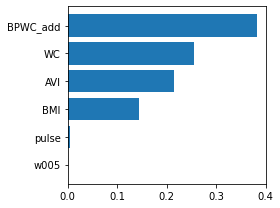

In [63]:
fts = get_feature_importance(tn_model.feature_importances_, X_train.columns,10)
#fts['feature']=['bWC','BP','leaf tea','lettuce']
plt.figure(figsize=(4,3))
new_name = ['BPWC_add', 'WC', 'AVI', 'BMI', 'pulse', 'w005']
plt.barh(new_name, fts['importance'])
#plt.barh(fts['feature'], fts['importance'])
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('./fig/feature_tabnet.png')
plt.show()

==== Calibration ====
Accuracy : 0.7427881199374734
Balanced Accuracy : 0.8131313564087597
Sensitivity :  0.9081967213114754
PPV :  0.3249902229174814
NPV :  0.98125
Specificity :  0.7180659915060438
F1 score :  0.47868663594470046
AUC :  0.8908521269701856


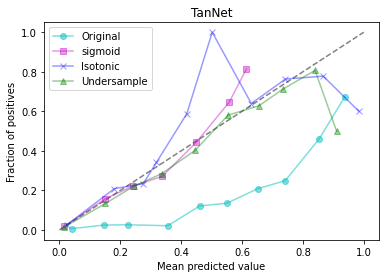

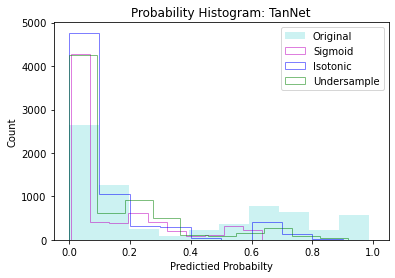

{'original': 0.15021158879439322, 'sigmoid': 0.0779930501065914, 'isotonic': 0.07736284290548323, 'underample': 0.07703933687042276} {'original': 14.31392948620137, 'sigmoid': -0.7963154012762309, 'isotonic': 1.3397549049201443, 'underample': -1.975541017028431} {'original': 1.791007963697491e-46, 'sigmoid': 0.42584873601469153, 'isotonic': 0.1803250409030447, 'underample': 0.048206784665914826}


In [39]:
score, z, p = calibrated_plot('TanNet', tn_model, X_train, y_train, X_valid, y_valid, X_test, y_test, beta, tau, is_tabnet=True)
print(score, z, p)